<a href="https://colab.research.google.com/github/dorinhazan/Human-Activity-Recognition-Using-Smartphones/blob/main/Activity_recognition_using_smartphone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
# Core libraries
import numpy as np
import pandas as pd
import warnings
import regex as re

# Plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# Scikit-learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.inspection import permutation_importance
from sklearn.manifold import TSNE
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# SHAP
import shap

Data loading

In [2]:
train_data = pd.read_csv('/content/train.csv')
test_data = pd.read_csv('/content/test.csv')

print(f'Shape of train data is: {train_data.shape}\nShape of test data is: {test_data.shape}')

Shape of train data is: (7352, 563)
Shape of test data is: (2947, 563)


In [3]:
train_data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


In [4]:
train_data.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject
count,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,...,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,0.274488,-0.017695,-0.109141,-0.605438,-0.510938,-0.604754,-0.630512,-0.526907,-0.606150,-0.468604,...,-0.307009,-0.625294,0.008684,0.002186,0.008726,-0.005981,-0.489547,0.058593,-0.056515,17.413085
std,0.070261,0.040811,0.056635,0.448734,0.502645,0.418687,0.424073,0.485942,0.414122,0.544547,...,0.321011,0.307584,0.336787,0.448306,0.608303,0.477975,0.511807,0.297480,0.279122,8.975143
min,-1.000000,-1.000000,-1.000000,-1.000000,-0.999873,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-0.995357,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000
25%,0.262975,-0.024863,-0.120993,-0.992754,-0.978129,-0.980233,-0.993591,-0.978162,-0.980251,-0.936219,...,-0.542602,-0.845573,-0.121527,-0.289549,-0.482273,-0.376341,-0.812065,-0.017885,-0.143414,8.000000
50%,0.277193,-0.017219,-0.108676,-0.946196,-0.851897,-0.859365,-0.950709,-0.857328,-0.857143,-0.881637,...,-0.343685,-0.711692,0.009509,0.008943,0.008735,-0.000368,-0.709417,0.182071,0.003181,19.000000
75%,0.288461,-0.010783,-0.097794,-0.242813,-0.034231,-0.262415,-0.292680,-0.066701,-0.265671,-0.017129,...,-0.126979,-0.503878,0.150865,0.292861,0.506187,0.359368,-0.509079,0.248353,0.107659,26.000000
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,1.000000,0.478157,1.000000,30.000000


In [5]:
print(train_data.isnull().sum())
print(test_data.isnull().sum())

tBodyAcc-mean()-X       0
tBodyAcc-mean()-Y       0
tBodyAcc-mean()-Z       0
tBodyAcc-std()-X        0
tBodyAcc-std()-Y        0
                       ..
angle(X,gravityMean)    0
angle(Y,gravityMean)    0
angle(Z,gravityMean)    0
subject                 0
Activity                0
Length: 563, dtype: int64
tBodyAcc-mean()-X       0
tBodyAcc-mean()-Y       0
tBodyAcc-mean()-Z       0
tBodyAcc-std()-X        0
tBodyAcc-std()-Y        0
                       ..
angle(X,gravityMean)    0
angle(Y,gravityMean)    0
angle(Z,gravityMean)    0
subject                 0
Activity                0
Length: 563, dtype: int64


Distribution - Human Activities In The Training Set

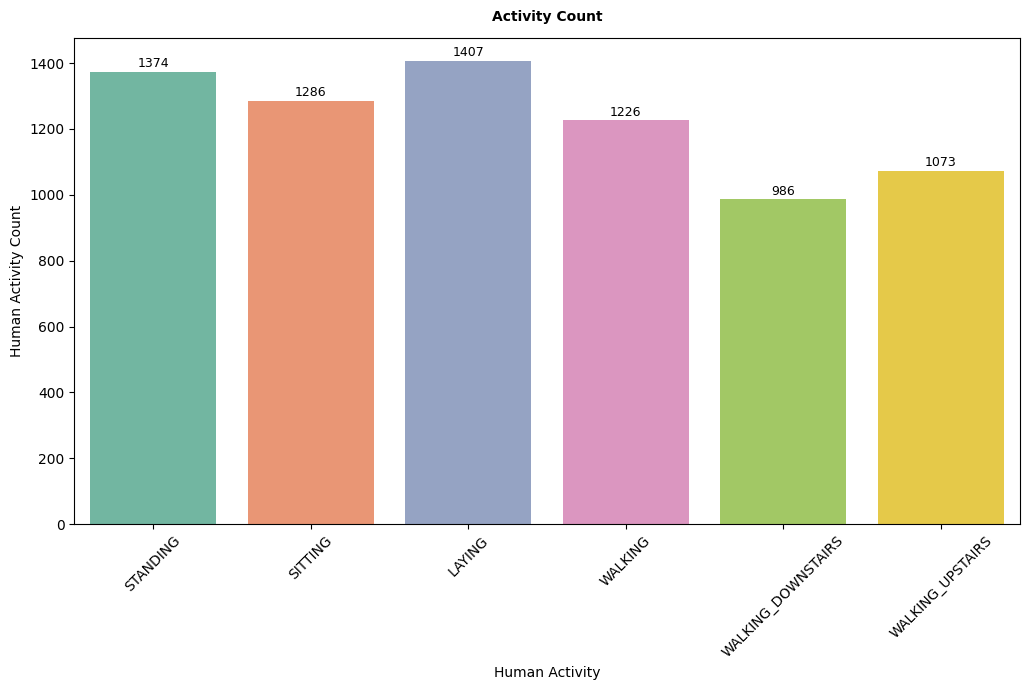

In [6]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(20, 7))

# Bar Chart
plt.subplot(1, 2, 1)
ax1 = sns.countplot(data=train_data, x='Activity', palette='Set2')
plt.title("Activity Count", pad=12, fontsize=10, fontweight='bold')
plt.xlabel('Human Activity')
plt.ylabel('Human Activity Count')
plt.xticks(rotation=45)

# Annotate each bar with its count
for patch in ax1.patches:
    height = patch.get_height()
    x = patch.get_x() + patch.get_width() / 2
    ax1.text(
        x, height + 5,
        f"{int(height)}",
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.tight_layout()
plt.show()


Subject Distribution Graph

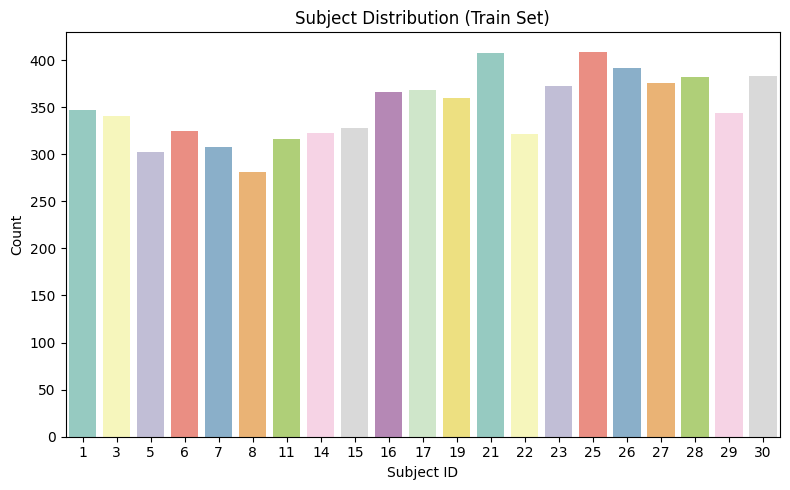

In [7]:
# Subject distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=train_data, x='subject', palette='Set3')
plt.title('Subject Distribution (Train Set)')
plt.xlabel('Subject ID')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

Data Splitting

In [8]:
X_train = train_data.drop(columns=['subject', 'Activity'])
y_train = train_data['Activity']
X_test  = test_data.drop(columns=['subject', 'Activity'])
y_test  = test_data['Activity']

In [9]:
X_train.shape, y_train.shape

((7352, 561), (7352,))

In [10]:
X_test.shape, y_test.shape

((2947, 561), (2947,))

Top Influential Features Identified by Mutual Information and Random Forest

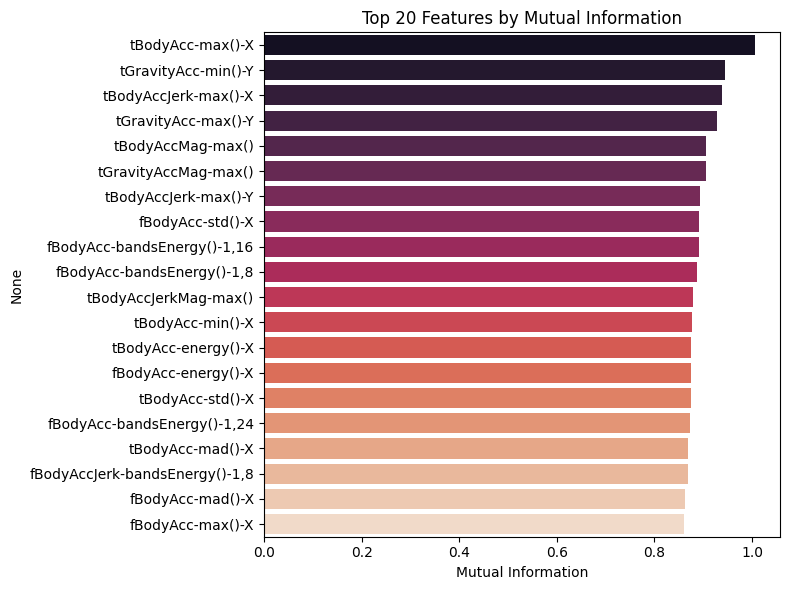

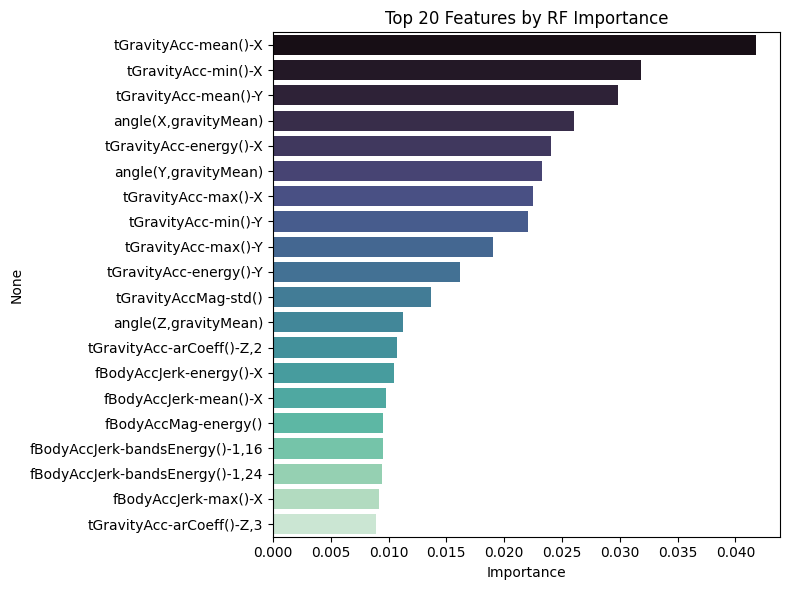

In [11]:
# Mutual-Information (MI) scores
mi_raw = mutual_info_classif(X_train, y_train, random_state=42)
mi_ser = pd.Series(mi_raw, index=X_train.columns, name="mi")
mi_top = mi_ser.sort_values(ascending=False).head(20)
plt.figure(figsize=(8, 6))
sns.barplot(x=mi_top.values, y=mi_top.index, palette="rocket")
plt.title("Top 20 Features by Mutual Information")
plt.xlabel("Mutual Information")
plt.tight_layout()
plt.show()

# Random-Forest importances
rf = RandomForestClassifier(
    n_estimators=200, n_jobs=-1, random_state=42
)
rf.fit(X_train, y_train)

imp_ser = pd.Series(rf.feature_importances_, index=X_train.columns, name="rf")

imp_top = imp_ser.sort_values(ascending=False).head(20)
plt.figure(figsize=(8, 6))
sns.barplot(x=imp_top.values, y=imp_top.index, palette="mako")
plt.title("Top 20 Features by RF Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


feat_df = pd.concat([mi_ser, imp_ser], axis=1)
weights = (
    feat_df.clip(lower=0)
            .apply(lambda col: col / col.sum()
                   if col.sum() > 0
                   else np.zeros_like(col))
)


weights["avg"] = weights.mean(axis=1)

PCA

In [12]:
# Cumulative-share cut-off
target_share = 0.95
cum_share = weights["avg"].sort_values(ascending=False).cumsum()

selected_features = cum_share[cum_share <= target_share].index.tolist()
actual_share = cum_share.loc[selected_features[-1]] if selected_features else 0

print(f"{len(selected_features)} features capture "
      f"{actual_share:.1%} of total importance "
      f"(target ≥ {target_share:.0%})")

# Keep only the 90% - importance features
X_sel_train = X_train[selected_features]
X_sel_test  = X_test[selected_features]

# PCA → retain ≥90% variance
pca = PCA(n_components=0.90, random_state=42)
X_train_pca_arr = pca.fit_transform(X_sel_train)
X_test_pca_arr  = pca.transform(X_sel_test)


explained_variance = np.round(pca.explained_variance_ratio_.sum() * 100, 2)
print(f"Explained variance by first 95% PCs: {explained_variance}%")

434 features capture 94.9% of total importance (target ≥ 95%)
Explained variance by first 95% PCs: 90.07%


t-SNE

In [13]:
# Run t-SNE on the PCA output
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    n_iter=1000,
    random_state=42,
    init="pca",
    verbose=1
)

X_embedded = tsne.fit_transform(X_train_pca_arr)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7352 samples in 0.047s...
[t-SNE] Computed neighbors for 7352 samples in 0.742s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7352
[t-SNE] Computed conditional probabilities for sample 2000 / 7352
[t-SNE] Computed conditional probabilities for sample 3000 / 7352
[t-SNE] Computed conditional probabilities for sample 4000 / 7352
[t-SNE] Computed conditional probabilities for sample 5000 / 7352
[t-SNE] Computed conditional probabilities for sample 6000 / 7352
[t-SNE] Computed conditional probabilities for sample 7000 / 7352
[t-SNE] Computed conditional probabilities for sample 7352 / 7352
[t-SNE] Mean sigma: 0.539986
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.631699
[t-SNE] KL divergence after 1000 iterations: 1.248075


Plot t-SNE

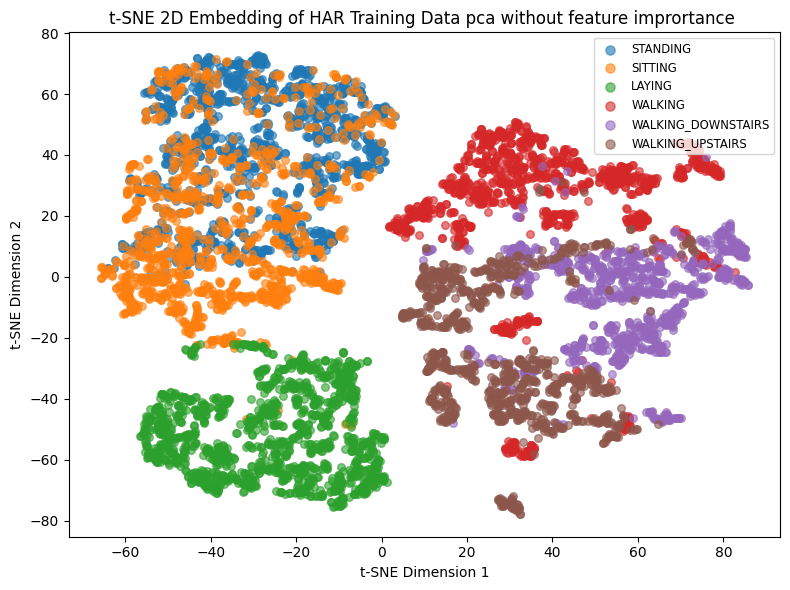

In [14]:
# Build a DataFrame for plotting the t-SNE result
embed_df = pd.DataFrame({
    "TSNE-1": X_embedded[:, 0],
    "TSNE-2": X_embedded[:, 1],
    "Activity": y_train.values
})

# Scatterplot: t-SNE embedding colored by Activity
plt.figure(figsize=(8, 6))
unique_acts = embed_df["Activity"].unique()
palette = sns.color_palette("tab10", len(unique_acts))

for idx, activity in enumerate(unique_acts):
    subset = embed_df[embed_df["Activity"] == activity]
    plt.scatter(
        subset["TSNE-1"],
        subset["TSNE-2"],
        label=activity,
        alpha=0.6,
        s=30,
        color=palette[idx]
    )

plt.title("t-SNE 2D Embedding of HAR Training Data pca without feature imprortance ")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(loc="best", fontsize="small", markerscale=1.2)
plt.tight_layout()
plt.show()

Confusion matrix using RandomForest

<Figure size 600x600 with 0 Axes>

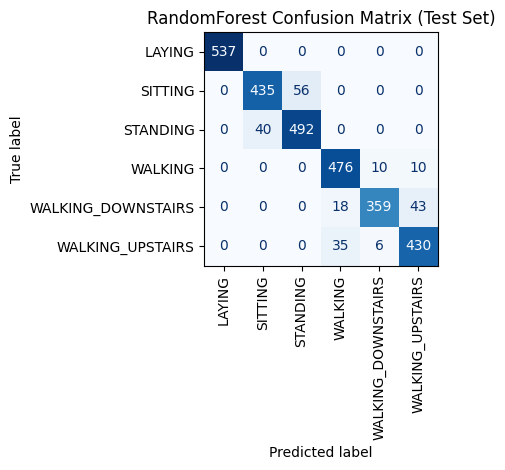

In [15]:
# Train a simple RandomForest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Predict on X_test and display the confusion matrix
y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)

plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", xticks_rotation="vertical", colorbar=False)
plt.title("RandomForest Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()

Model

In [16]:
# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train.values.ravel())
y_test_enc  = le.transform(y_test.values.ravel())
num_classes = len(le.classes_)

# One-hot encode
y_train_cat = tf.keras.utils.to_categorical(y_train_enc, num_classes)
y_test_cat  = tf.keras.utils.to_categorical(y_test_enc, num_classes)

# Learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

def dnn_model(input_dim, num_classes):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),

        layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.4),

        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Train
model = dnn_model(X_train_pca_arr.shape[1], num_classes)
early_stop = callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(
    X_train_pca_arr, y_train_cat,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=[early_stop],
    verbose=2
)

# Evaluate
y_pred_proba = model.predict(X_test_pca_arr)
y_pred_label = y_pred_proba.argmax(axis=1)


Epoch 1/100
92/92 - 8s - 87ms/step - accuracy: 0.7832 - loss: 0.6744 - val_accuracy: 0.7689 - val_loss: 0.8125
Epoch 2/100
92/92 - 3s - 33ms/step - accuracy: 0.8434 - loss: 0.5002 - val_accuracy: 0.8314 - val_loss: 0.6436
Epoch 3/100
92/92 - 4s - 48ms/step - accuracy: 0.8650 - loss: 0.4535 - val_accuracy: 0.8600 - val_loss: 0.4729
Epoch 4/100
92/92 - 2s - 27ms/step - accuracy: 0.8777 - loss: 0.4321 - val_accuracy: 0.8742 - val_loss: 0.4109
Epoch 5/100
92/92 - 3s - 28ms/step - accuracy: 0.8776 - loss: 0.4101 - val_accuracy: 0.8824 - val_loss: 0.4003
Epoch 6/100
92/92 - 3s - 35ms/step - accuracy: 0.8893 - loss: 0.3889 - val_accuracy: 0.8960 - val_loss: 0.3626
Epoch 7/100
92/92 - 4s - 47ms/step - accuracy: 0.8888 - loss: 0.3846 - val_accuracy: 0.8708 - val_loss: 0.4336
Epoch 8/100
92/92 - 3s - 28ms/step - accuracy: 0.8947 - loss: 0.3681 - val_accuracy: 0.8960 - val_loss: 0.3631
Epoch 9/100
92/92 - 2s - 27ms/step - accuracy: 0.9012 - loss: 0.3608 - val_accuracy: 0.8804 - val_loss: 0.4327
E

In [17]:
report_dict = classification_report(y_test_enc, y_pred_label, target_names=le.classes_, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()
print("Summary Metrics:")
for label in ['accuracy', 'macro avg', 'weighted avg']:
    row = report_dict[label]
    if label == 'accuracy':
        print(f"Accuracy: {row:.3f}")
    else:
        print(f"{label.title()} – Precision: {row['precision']:.3f}, Recall: {row['recall']:.3f}, F1-score: {row['f1-score']:.3f}")

Summary Metrics:
Accuracy: 0.868
Macro Avg – Precision: 0.874, Recall: 0.864, F1-score: 0.864
Weighted Avg – Precision: 0.874, Recall: 0.868, F1-score: 0.866


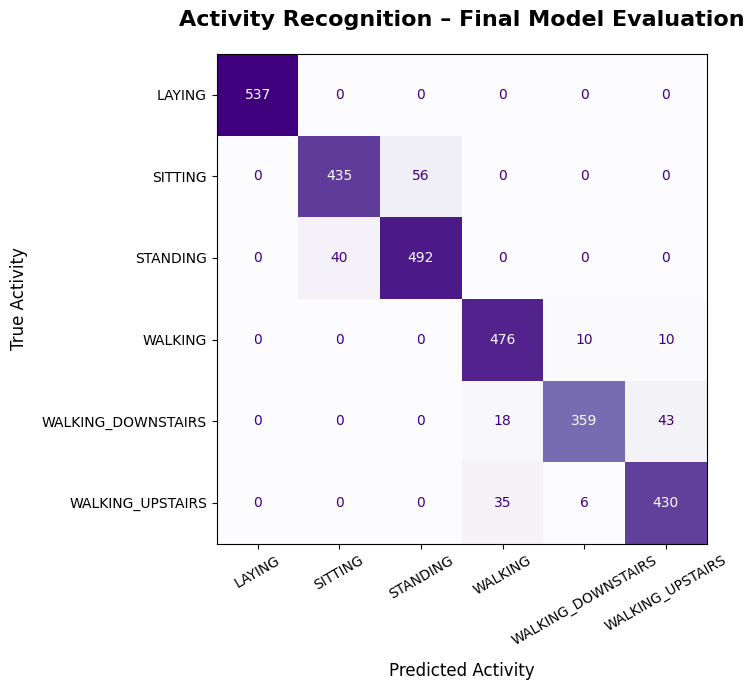

In [18]:
# Confusion Matrix
fig, ax = plt.subplots(figsize=(9, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Purples', ax=ax, values_format='d', colorbar=False)

# Styling
ax.set_title("Activity Recognition – Final Model Evaluation", fontsize=16, weight='bold', pad=20)
ax.set_xlabel("Predicted Activity", fontsize=12, labelpad=10)
ax.set_ylabel("True Activity", fontsize=12, labelpad=10)
ax.tick_params(axis='x', rotation=30)
ax.tick_params(axis='both', labelsize=10)
plt.grid(False)
plt.tight_layout()
plt.show()

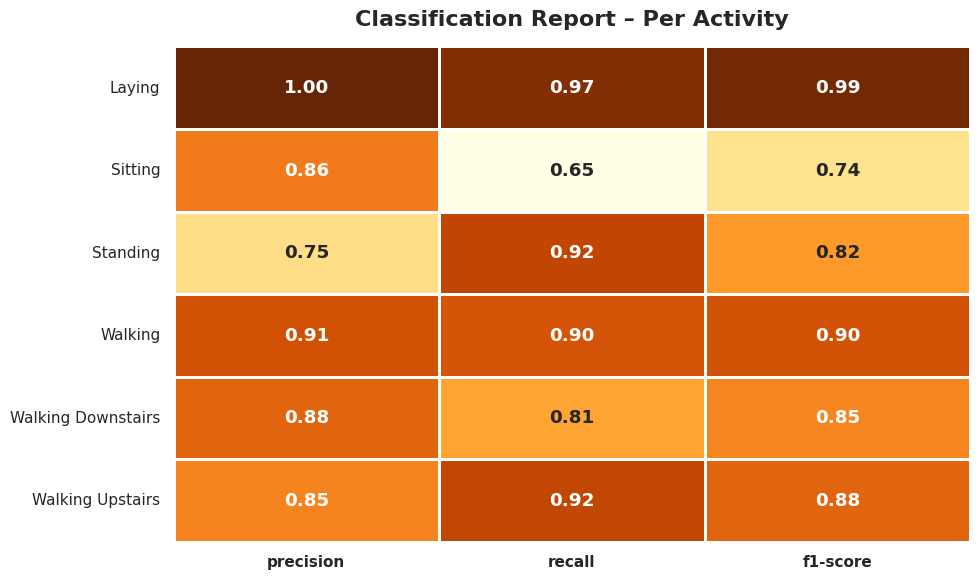

In [19]:
# Generate classification report as dict
report_dict = classification_report(y_test_enc, y_pred_label, target_names=le.classes_, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()

df_summary = df_report.loc[['accuracy', 'macro avg', 'weighted avg']]
df_main = df_report.drop(index=['accuracy', 'macro avg', 'weighted avg'])
df_main.index = [label.replace('_', ' ').title() for label in df_main.index]

plt.figure(figsize=(10, 6))
sns.set(style="white", font_scale=1.1)
ax = sns.heatmap(
    df_main.iloc[:, :3],
    annot=True,
    fmt=".2f",
    cmap="YlOrBr",
    linewidths=0.8,
    linecolor='white',
    cbar=False,
    annot_kws={"weight": "bold"}
)

plt.title("Classification Report – Per Activity", fontsize=16, weight='bold', pad=15)
plt.xticks(rotation=0, ha='center', fontsize=11, weight='bold')
plt.yticks(rotation=0, fontsize=11)
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.show()

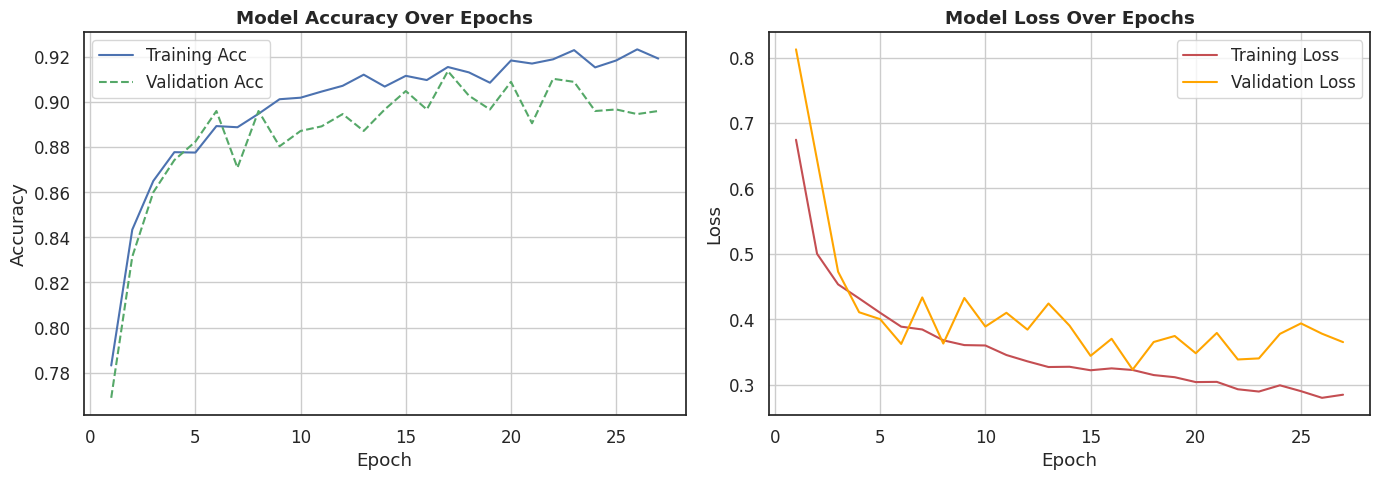

In [20]:
# Training History Plot
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Acc')
    plt.plot(epochs, val_acc, 'g--', label='Validation Acc')
    plt.title('Model Accuracy Over Epochs', weight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r-', label='Training Loss')
    plt.plot(epochs, val_loss, 'orange', label='Validation Loss')
    plt.title('Model Loss Over Epochs', weight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)